# Predicting AirBnb Review Scores

In this document we will be:
* Creating violin plots of variables in order to ascertain a reasonable response variable
* Preparing the data for a prediction model on the response variable
* Assessing model performance and looking at feature importance

Firstly, we will import all the relevant libraries.

In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import RidgeCV

import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/seattle/reviews.csv
/kaggle/input/seattle/calendar.csv
/kaggle/input/seattle/listings.csv


We will be using the listings dataset only.

In [75]:
l = pd.read_csv('../input/seattle/listings.csv')

Let's see the value counts of the various neighbourhoods.

In [76]:
l['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64

We will see how the University District reviews scores compare against the other listings using the violin plot.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


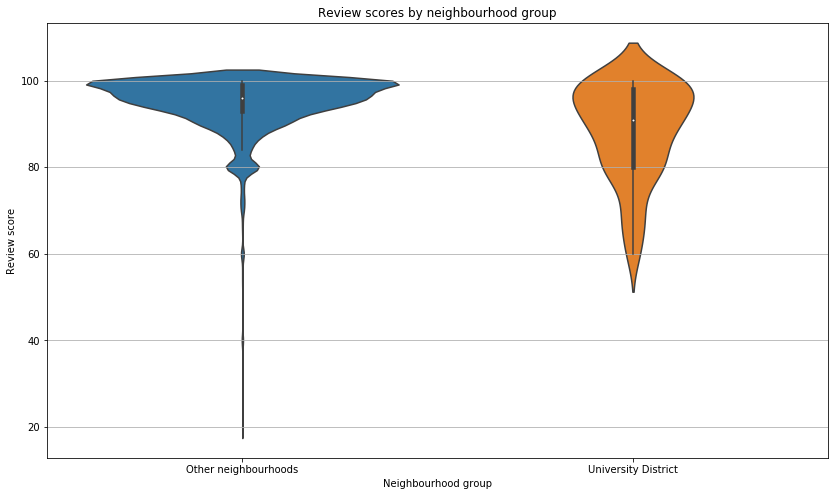

In [77]:
fontsize = 10

df_temp = l[['neighbourhood_group_cleansed', 'review_scores_rating']]
df_temp['n'] = np.where(
    df_temp['neighbourhood_group_cleansed'] == 'University District', 
    'University District', 'Other neighbourhoods'
)

fig, axes = plt.subplots(figsize=(14, 8))
sns.violinplot('n','review_scores_rating', data=df_temp, ax = axes)
axes.set_title('Review scores by neighbourhood group')

axes.yaxis.grid(True)
axes.set_xlabel('Neighbourhood group')
axes.set_ylabel('Review score')

plt.show()

Next, we have a violin plot of the reviews per month.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


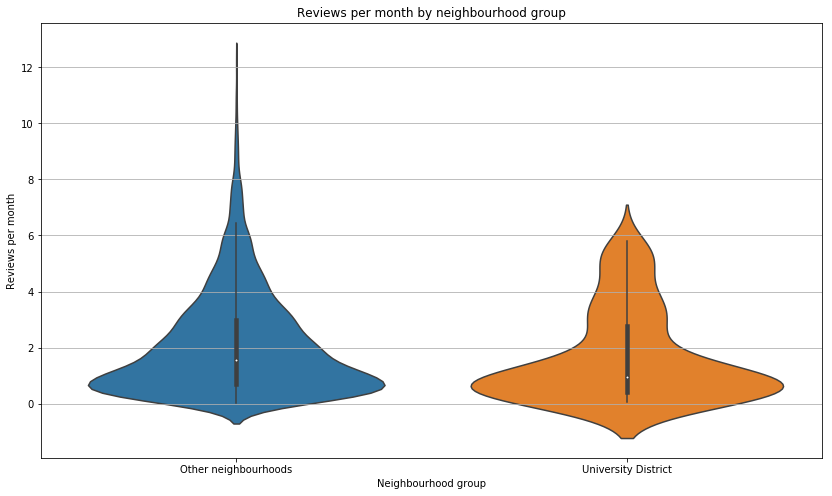

In [78]:
fontsize = 10

df_temp = l[['neighbourhood_group_cleansed', 'reviews_per_month']]
df_temp['n'] = np.where(
    df_temp['neighbourhood_group_cleansed'] == 'University District', 
    'University District', 'Other neighbourhoods'
)

fig, axes = plt.subplots(figsize=(14, 8))
sns.violinplot('n','reviews_per_month', data=df_temp, ax = axes)
axes.set_title('Reviews per month by neighbourhood group')

axes.yaxis.grid(True)
axes.set_xlabel('Neighbourhood group')
axes.set_ylabel('Reviews per month')

plt.show()

Finally, we decide on the combination of review score and reviews per month for the CX score and inspect its distribution.

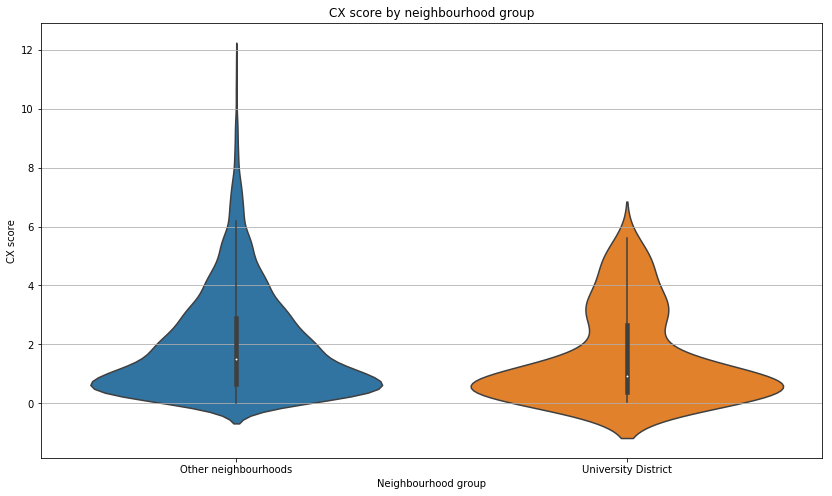

In [79]:
fontsize = 10

df_temp = l[['neighbourhood_group_cleansed', 'review_scores_rating', 'reviews_per_month']].copy()
df_temp['cx_score'] = df_temp['review_scores_rating'] / 100 * df_temp['reviews_per_month']
df_temp['n'] = np.where(
    df_temp['neighbourhood_group_cleansed'] == 'University District', 
    'University District', 'Other neighbourhoods'
)

fig, axes = plt.subplots(figsize=(14, 8))
sns.violinplot('n','cx_score', data=df_temp, ax = axes)
axes.set_title('CX score by neighbourhood group')

axes.yaxis.grid(True)
axes.set_xlabel('Neighbourhood group')
axes.set_ylabel('CX score')

plt.show()

We will just filter the data to the University District for more accurate results.

In [80]:
df = l.copy()
df = df.loc[df['neighbourhood_group_cleansed'] == 'University District']

Various functions for preprocessing each variable are given below.

In [81]:
def convert_host_since(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['days_as_host'] = (pd.to_datetime(df['last_scraped']) - pd.to_datetime(df['host_since'])) / np.timedelta64(1, 'D')
    
    df = df.drop(['last_scraped', 'host_since'], axis=1)
    
    return df

def convert_host_location(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """

    df['host_in_seattle'] = df['host_location'].str.contains('Seattle')
    
    df = df.drop(['host_location'], axis=1)
    
    return df

def convert_host_about(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['has_host_about'] = ~df['host_about'].isnull()
    
    df = df.drop(['host_about'], axis=1)
    
    return df

def convert_host_response_time(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['host_response_time'] = np.where(
        df['host_response_time'].eq('within an hour'), 1,
        np.where(
            df['host_response_time'].eq('within a few hours'), 2,
            np.where(
                df['host_response_time'].eq('within a day'), 3, 4
            )
        )
    )
    
    return df

def convert_host_response_rate(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['host_response_rate'] = df['host_response_rate'].str.replace(r'%', r'.0').astype('float') / 100.0
    
    return df

def convert_host_neighbourhood(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['host_in_neighbourhood'] = np.where(
        df['host_neighbourhood'] == df['neighbourhood'], True, 
        np.where(
            df['host_neighbourhood'] == df['neighbourhood_cleansed'], True,
            np.where(
                df['host_neighbourhood'] == df['neighbourhood_group_cleansed'], True, False
            )
        )
    )
    
    df = df.drop(['host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed'], axis=1)
    
    return df

def convert_host_verifications(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['host_verif_email'] = df['host_verifications'].str.contains('email')
    df['host_verif_kba'] = df['host_verifications'].str.contains('kba')
    df['host_verif_phone'] = df['host_verifications'].str.contains('phone')
    df['host_verif_reviews'] = df['host_verifications'].str.contains('reviews')
    df['host_verif_jumio'] = df['host_verifications'].str.contains('jumio')
    df['host_verif_facebook'] = df['host_verifications'].str.contains('facebook')
    df['host_verif_linkedin'] = df['host_verifications'].str.contains('linkedin')
    df['host_verif_google'] = df['host_verifications'].str.contains('google')
    df['host_verif_manual_online'] = df['host_verifications'].str.contains('manual_online')
    df['host_verif_manual_offline'] = df['host_verifications'].str.contains('manual_offline')
    df['host_verif_sent_id'] = df['host_verifications'].str.contains('sent_id')
    df['host_verif_amex'] = df['host_verifications'].str.contains('amex')
    df['host_verif_weibo'] = df['host_verifications'].str.contains('weibo')
    df['host_verif_photographer'] = df['host_verifications'].str.contains('photographer')
    
    df = df.drop(['host_verifications'], axis=1)
    
    return df

def convert_host_has_profile_pic(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['host_has_profile_pic'] = np.where(df['host_has_profile_pic'] == 't', True, False)
    
    return df

def convert_host_identity_verified(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['host_identity_verified'] = np.where(df['host_identity_verified'] == 't', True, False)
    
    return df

def convert_bed_type(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['real_bed'] = np.where(
        df['bed_type'] == 'Real Bed', True, False
    )
    
    df = df.drop(['bed_type'], axis=1)
    
    return df

def convert_amenities(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['amenities_tv'] = df['amenities'].str.contains('TV')
    df['amenities_internet'] = df['amenities'].str.contains('Internet')
    df['amenities_wireless_internet'] = df['amenities'].str.contains('Wireless Internet')
    df['amenities_cable_tv'] = df['amenities'].str.contains('Cable TV')
    df['amenities_kitchen'] = df['amenities'].str.contains('Kitchen')
    df['amenities_elevator_in_building'] = df['amenities'].str.contains('Elevator in Building')
    df['amenities_wheelchair_accessible'] = df['amenities'].str.contains('Wheelchair Accessible')
    df['amenities_smoke_detector'] = df['amenities'].str.contains('Smoke Detector')
    df['amenities_pool'] = df['amenities'].str.contains('Pool')
    df['amenities_free_parking_on_premises'] = df['amenities'].str.contains('Free Parking on Premises')
    df['amenities_air_conditioning'] = df['amenities'].str.contains('Air Conditioning')
    df['amenities_heating'] = df['amenities'].str.contains('Heating')
    df['amenities_pets_live_on_this_property'] = df['amenities'].str.contains('Pets live on this property')
    df['amenities_washer'] = df['amenities'].str.contains('Washer')
    df['amenities_breakfast'] = df['amenities'].str.contains('Breakfast')
    df['amenities_buzzer_wireless_intercom'] = df['amenities'].str.contains('Buzzer/Wireless Intercom')
    df['amenities_pets_allowed'] = df['amenities'].str.contains('Pets Allowed')
    df['amenities_carbon_monoxide_detector'] = df['amenities'].str.contains('Carbon Monoxide Detector')
    df['amenities_gym'] = df['amenities'].str.contains('Gym')
    df['amenities_dryer'] = df['amenities'].str.contains('Dryer')
    df['amenities_indoor_fireplace'] = df['amenities'].str.contains('Indoor Fireplace')
    df['amenities_family_kid_friendly'] = df['amenities'].str.contains('Family/Kid Friendly')
    df['amenities_dogs'] = df['amenities'].str.contains('Dog(s)')
    df['amenities_essentials'] = df['amenities'].str.contains('Essentials')
    df['amenities_cats'] = df['amenities'].str.contains('Cat(s)')
    df['amenities_hot_tub'] = df['amenities'].str.contains('Hot Tub')
    df['amenities_shampoo'] = df['amenities'].str.contains('Shampoo')
    df['amenities_first_aid_kit'] = df['amenities'].str.contains('First Aid Kit')
    df['amenities_smoking_allowed'] = df['amenities'].str.contains('Smoking Allowed')
    df['amenities_fire_extinguisher'] = df['amenities'].str.contains('Fire Extinguisher')
    df['amenities_doorman'] = df['amenities'].str.contains('Doorman')
    df['amenities_washer_dryer'] = df['amenities'].str.contains('Washer / Dryer')
    df['amenities_safety_card'] = df['amenities'].str.contains('Safety Card')
    df['amenities_suitable_for_events'] = df['amenities'].str.contains('Suitable for Events')
    df['amenities_other_pets'] = df['amenities'].str.contains('Other pet(s)')
    df['amenities_24_hour_check_in'] = df['amenities'].str.contains('24-Hour Check-in')
    df['amenities_hangers'] = df['amenities'].str.contains('Hangers')
    df['amenities_laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop Friendly Workspace')
    df['amenities_iron'] = df['amenities'].str.contains('Iron')
    df['amenities_hair_dryer'] = df['amenities'].str.contains('Hair Dryer')
    df['amenities_lock_on_bedroom_door'] = df['amenities'].str.contains('Lock on Bedroom Door')
    
    df = df.drop(['amenities'], axis=1)
    
    return df

def convert_weekly_price(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['weekly_price_ratio'] = df['weekly_price'].replace('[\$,]', '', regex=True).astype(float) / \
        df['price'].replace('[\$,]', '', regex=True).astype(float)
        
    df['has_weekly_price'] = ~df['weekly_price'].isnull()
    
    df['weekly_price'] = df['weekly_price'].replace('[\$,]', '', regex=True).astype(float)
    
    return df

def convert_monthly_price(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['monthly_price_ratio'] = df['monthly_price'].replace('[\$,]', '', regex=True).astype(float) / \
        df['price'].replace('[\$,]', '', regex=True).astype(float)
        
    df['has_monthly_price'] = ~df['monthly_price'].isnull()
    
    df['monthly_price'] = df['monthly_price'].replace('[\$,]', '', regex=True).astype(float)
    
    return df

def convert_security_deposit(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['security_deposit_ratio'] = df['security_deposit'].replace('[\$,]', '', regex=True).astype(float) / \
        df['price'].replace('[\$,]', '', regex=True).astype(float)
        
    df['has_security_deposit'] = ~df['security_deposit'].isnull()
    
    df['security_deposit'] = df['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
    
    return df

def convert_cleaning_fee(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['cleaning_fee_ratio'] = df['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float) / \
        df['price'].replace('[\$,]', '', regex=True).astype(float)
        
    df['has_cleaning_fee'] = ~df['cleaning_fee'].isnull()
    
    df['cleaning_fee'] = df['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
    
    return df

def convert_extra_people(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['extra_people_ratio'] = df['extra_people'].replace('[\$,]', '', regex=True).astype(float) / \
        df['price'].replace('[\$,]', '', regex=True).astype(float)
    
    df['extra_people'] = df['extra_people'].replace('[\$,]', '', regex=True).astype(float)
    
    return df

def convert_instant_bookable(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['instant_bookable'] = np.where(df['instant_bookable'] == 't', True, False)
    
    return df

def convert_cancellation_policy(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    new_data = pd.get_dummies(df[['cancellation_policy']])
    df[new_data.columns] = new_data
    
    df = df.drop(['cancellation_policy'], axis=1)
    
    return df, new_data.columns

def convert_require_guest_profile_picture(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['require_guest_profile_picture'] = np.where(df['require_guest_profile_picture'] == 't', True, False)
    
    return df

def convert_require_guest_phone_verification(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['require_guest_phone_verification'] = np.where(df['require_guest_phone_verification'] == 't', True, False)
    
    return df

def convert_price(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    
    return df

def convert_host_is_superhost(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['host_is_superhost'] = np.where(df['host_is_superhost'] == 't', True, False)
    
    return df

def convert_is_location_exact(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['is_location_exact'] = np.where(df['is_location_exact'] == 't', True, False)
    
    return df

def convert_neighbourhood_cleansed(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    new_data = pd.get_dummies(df[['neighbourhood_cleansed']])
    df[new_data.columns] = new_data
    
    return df, new_data.columns

def convert_neighbourhood_group_cleansed(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    new_data = pd.get_dummies(df[['neighbourhood_group_cleansed']])
    df[new_data.columns] = new_data
    
    return df, new_data.columns

def convert_property_type(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['property_type'] = np.where(
        df['property_type'] == 'House', 'House',
        np.where(
            df['property_type'] == 'Apartment', 'Apartment',
            np.where(
                df['property_type'] == 'Townhouse', 'Townhouse',
                'Other'
            )
        )
    )
    
    new_data = pd.get_dummies(df[['property_type']])
    df[new_data.columns] = new_data
    
    df = df.drop(['property_type'], axis=1)
    
    return df, new_data.columns

def convert_minimum_nights(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['has_minimum_nights'] = np.where(df['minimum_nights'] > 0, True, False)
    
    return df

def convert_maximum_nights(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the modified dataset containing the transformed features
    """
    
    df['has_maximum_nights'] = np.where(df['maximum_nights'] > 0, True, False)
    
    return df

The preprocessing functions for the data are combined together in the following overall dataset preprocessing function.

In [82]:
def convert_df(df):
    """
    Input: df - a dataset containing the unprocessed column's data
    Output: df - the fully pre-processed dataset
    """
    
    # dummies
    df, cols_neighbourhood_cleansed = convert_neighbourhood_cleansed(df)
    df, cols_neighbourhood_group_cleansed = convert_neighbourhood_group_cleansed(df)
    df, cols_property_type = convert_property_type(df)
    df, cols_cancellation_policy = convert_cancellation_policy(df)
    
    cols_dummies = []
    cols_dummies.extend(cols_neighbourhood_cleansed)
    cols_dummies.extend(cols_neighbourhood_group_cleansed)
    cols_dummies.extend(cols_property_type)
    cols_dummies.extend(cols_cancellation_policy)
    
    # map columns to new variables
    df = convert_host_since(df)
    df = convert_host_location(df)
    df = convert_host_about(df)
    df = convert_host_response_time(df)
    df = convert_host_response_rate(df)
    df = convert_host_neighbourhood(df)
    df = convert_host_verifications(df)
    df = convert_host_has_profile_pic(df)
    df = convert_host_identity_verified(df)
    df = convert_bed_type(df)
    df = convert_amenities(df)
    df = convert_weekly_price(df)
    df = convert_monthly_price(df)
    df = convert_security_deposit(df)
    df = convert_cleaning_fee(df)
    df = convert_extra_people(df)
    df = convert_instant_bookable(df)
    df = convert_require_guest_profile_picture(df)
    df = convert_require_guest_phone_verification(df)
    df = convert_price(df)
    df = convert_host_is_superhost(df)
    df = convert_is_location_exact(df)
    df = convert_minimum_nights(df)
    df = convert_maximum_nights(df)
    
    # fill NaN values with reasonable values
    df['days_as_host'] = df['days_as_host'].fillna(df['days_as_host'].median())
    df['host_in_seattle'] = df['host_in_seattle'].fillna(df['host_in_seattle'].median())
    df['host_response_rate'] = df['host_response_rate'].fillna(1.0)
    df['weekly_price'] = df['weekly_price'].fillna(0.0)
    df['monthly_price'] = df['monthly_price'].fillna(0.0)
    df['security_deposit'] = df['security_deposit'].fillna(0.0)
    df['cleaning_fee'] = df['cleaning_fee'].fillna(0.0)
    df['extra_people'] = df['extra_people'].fillna(0.0)
    df['weekly_price_ratio'] = df['weekly_price_ratio'].fillna(0.0)
    df['monthly_price_ratio'] = df['monthly_price_ratio'].fillna(0.0)
    df['security_deposit_ratio'] = df['security_deposit_ratio'].fillna(0.0)
    df['cleaning_fee_ratio'] = df['cleaning_fee_ratio'].fillna(0.0)
    
    df['accommodates'] = df['accommodates'].fillna(df['accommodates'].median())
    df['bathrooms'] = df['bathrooms'].fillna(0)
    df['bedrooms'] = df['bedrooms'].fillna(0)
    df['beds'] = df['beds'].fillna(0)
    
    cols = ['review_scores_rating', 'number_of_reviews', 'reviews_per_month',
          'host_id', 'days_as_host', 'host_in_seattle', 'has_host_about', 'host_response_time',
          'host_response_rate', 'host_in_neighbourhood', 'host_verif_email', 'host_verif_kba',
          'host_verif_phone', 'host_verif_reviews', 'host_verif_jumio', 'host_verif_facebook',
          'host_verif_linkedin', 'host_verif_google', 'host_verif_manual_online',
          'host_verif_manual_offline', 'host_verif_sent_id', 'host_verif_amex',
          'host_verif_weibo', 'host_verif_photographer', 'host_has_profile_pic',
          'host_identity_verified', 'real_bed', 'amenities_tv', 'amenities_internet',
          'amenities_wireless_internet', 'amenities_cable_tv', 'amenities_kitchen',
          'amenities_elevator_in_building', 'amenities_wheelchair_accessible',
          'amenities_smoke_detector', 'amenities_pool', 'amenities_free_parking_on_premises',
          'amenities_air_conditioning', 'amenities_heating', 'amenities_pets_live_on_this_property',
          'amenities_washer', 'amenities_breakfast', 'amenities_buzzer_wireless_intercom',
          'amenities_pets_allowed', 'amenities_carbon_monoxide_detector', 'amenities_gym',
          'amenities_dryer', 'amenities_indoor_fireplace', 'amenities_family_kid_friendly',
          'amenities_dogs', 'amenities_essentials', 'amenities_cats', 'amenities_hot_tub',
          'amenities_shampoo', 'amenities_first_aid_kit', 'amenities_smoking_allowed',
          'amenities_fire_extinguisher', 'amenities_doorman', 'amenities_washer_dryer',
          'amenities_safety_card', 'amenities_suitable_for_events', 'amenities_other_pets',
          'amenities_24_hour_check_in', 'amenities_hangers', 'amenities_laptop_friendly_workspace',
          'amenities_iron', 'amenities_hair_dryer', 'amenities_lock_on_bedroom_door',
          'weekly_price_ratio', 'has_weekly_price', 'monthly_price_ratio', 'has_monthly_price',
          'security_deposit_ratio', 'has_security_deposit', 'cleaning_fee_ratio',
          'has_cleaning_fee', 'extra_people_ratio', 'instant_bookable',
          'require_guest_profile_picture', 'require_guest_phone_verification',
          'minimum_nights', 'maximum_nights', 'price', 'host_is_superhost', 'is_location_exact',
          'accommodates', 'bathrooms', 'bedrooms', 'beds',
           'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
           'has_minimum_nights', 'has_maximum_nights']
    
    cols.extend(cols_dummies)
                        
    # Select only columns needed for analysis
    df = df.loc[:, cols]
    
    # Remove rows with null values for response variable
    df = df.dropna(subset=['review_scores_rating'])
    
    # Convert the review scores to a decimal
    df['review_scores_rating'] = df['review_scores_rating'] / 100
    
    # The given calculation for the customer experience score
    df['cx_score'] = df['review_scores_rating'] * df['reviews_per_month']
    
    return df, cols_dummies

We will now apply the preprocessing function to the data.

In [83]:
df, cols_dummies = convert_df(df)

/opt/conda/lib/python3.6/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


A histogram of the response variable is given below.

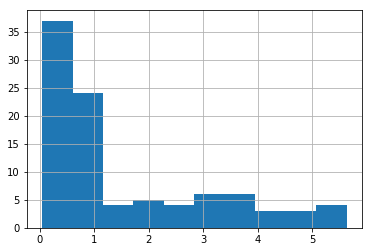

In [84]:
df['cx_score'].hist()

We will drop the unnecessary columns from the data for modelling.

In [85]:
df3 = df.copy()
try:
    df3 = df3.drop(['reviews_per_month'], axis=1)
except:
    pass
try:
    df3 = df3.drop(['number_of_reviews'], axis=1)
except:
    pass
try:
    df3 = df3.drop(['review_scores_rating'], axis=1)
except:
    pass
try:
    df3 = df3.drop(['host_id'], axis=1)
except:
    pass

Let's plot the most correlated features with the response variable.

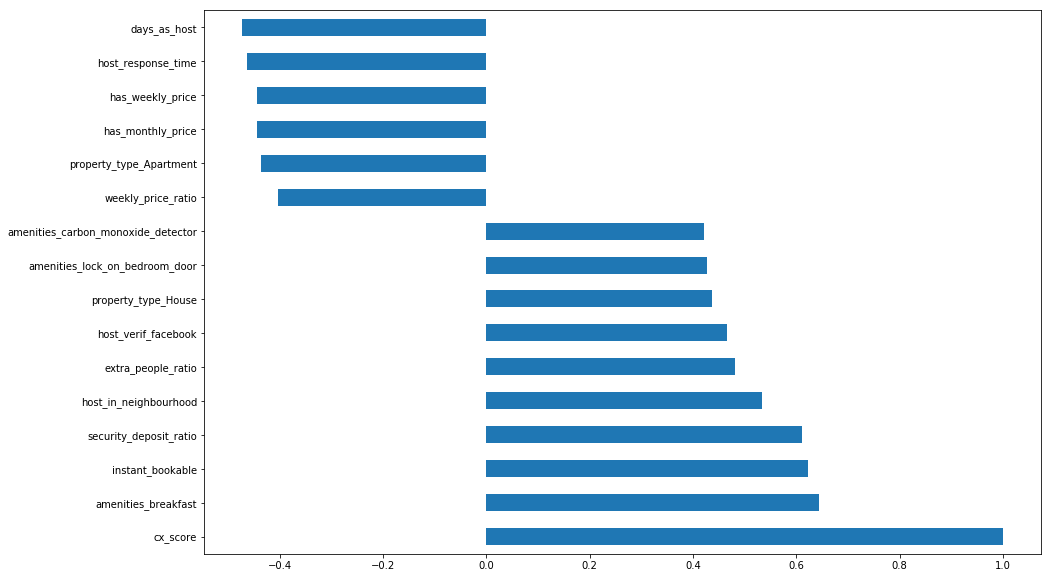

In [86]:
corr = df3.corr()
corr_y = corr['cx_score']
fontsize = 10
plt.figure(figsize=(15,10))
corr_y[np.abs(corr_y) > 0.4].sort_values(ascending=False).plot.barh()

Let's take only the features which have at least magnitude 0.2 correlation with the response variable.

In [87]:
df3 = df3[corr_y[np.abs(corr_y) > 0.2].index.values]

Now let's create the train test split of the data, and separate the response variable from the other features. We then fit an OLS regression on the data and print the R2 score of the training data.

In [88]:
train, test = train_test_split(df3, test_size=0.3, random_state=0)

X_train = train.drop(['cx_score'], axis=1)
y_train = train['cx_score']

X_test = test.drop(['cx_score'], axis=1)
y_test = test['cx_score']

ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)
y_train_preds = ols.predict(X_train)
r2_score(y_train, y_train_preds)

0.952208824940707

This is a very good score. Let's see also the RMSE.

In [89]:
np.sqrt(mean_squared_error(y_train, y_train_preds))

0.3443032777023525

Now let's see how well the OLS model performs on the test data.

In [90]:
y_test_preds = ols.predict(X_test)
r2_score(y_test, y_test_preds)

-0.7532033863279339

This R2 score is very bad.

In [91]:
np.sqrt(mean_squared_error(y_test, y_test_preds))

1.812134705008053

The RMSE score is also bad. Let's try another model, such as ridge regression. We will use cross-validation with 6 folds.

In [92]:
reg = RidgeCV(cv=6)
reg.fit(X_train, y_train)
reg.score(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8751498461221102

The R2 score on the training data is not as good as before, but let's check how it performs on the test data.

In [93]:
reg.score(X_test, y_test)

0.6313119020259998

The R2 score is reasonable, so we can accept this model.

In [94]:
y_test_preds = reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_test_preds))

0.8310054773879055

The test RMSE is much better than before. Now let's have a look at the coefficients of the model to understand feature importance. Firstly, we list the top 5 features with positive coefficients.

In [95]:
coefs = pd.DataFrame(reg.coef_, index=X_train.columns)
coefs.columns = ['Coefficient']
coefs.sort_values(by=['Coefficient'], ascending=False).head(5)

,Coefficient
instant_bookable,0.307273
host_verif_facebook,0.292242
amenities_safety_card,0.198168
accommodates,0.169957
amenities_breakfast,0.151450


Next we show the 5 features with the most negative coefficients

In [96]:
coefs.sort_values(by=['Coefficient'], ascending=True).head(5)

,Coefficient
host_response_time,-0.319324
is_location_exact,-0.218903
cancellation_policy_moderate,-0.177780
amenities_cable_tv,-0.159561
minimum_nights,-0.132923
